In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
# Core Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Machine Learning - Regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             mean_absolute_percentage_error)

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr

print("✅ All libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"📊 Dataset: 100,000 Insurance Records | 54+ Features")



✅ All libraries imported successfully!
📦 Pandas version: 3.0.0
📦 NumPy version: 2.4.2
📊 Dataset: 100,000 Insurance Records | 54+ Features


In [28]:
df = pd.read_csv("medical_insurance.csv")

<Axes: >

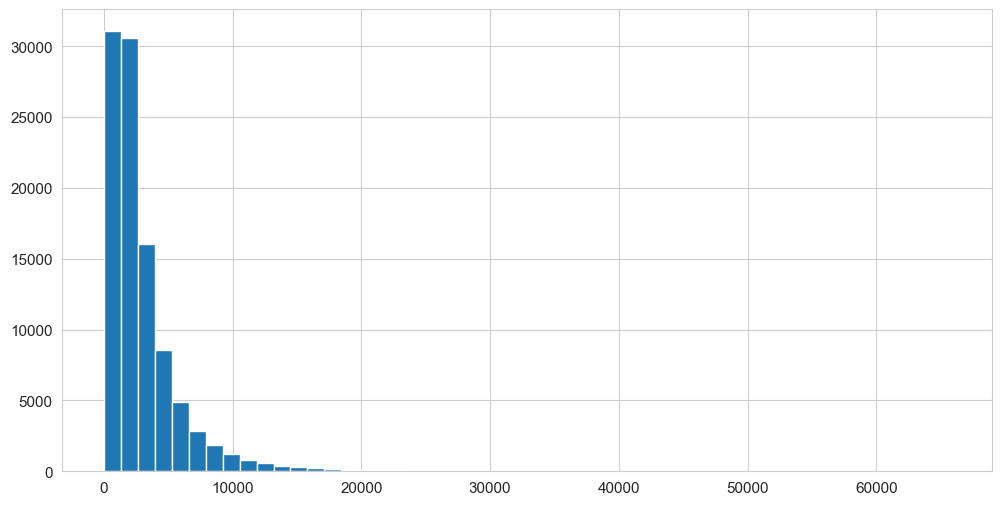

In [29]:
df['annual_medical_cost'].hist(bins=50)

In [30]:
data = df.copy()
data['alcohol_freq'].fillna('Others',inplace=True)

0            Others
1            Weekly
2            Others
3            Others
4             Daily
            ...    
99995    Occasional
99996    Occasional
99997        Weekly
99998    Occasional
99999        Others
Name: alcohol_freq, Length: 100000, dtype: str

In [31]:
alcohol_map = {'Never': 0, 'Occasional': 1, 'Frequent': 4, 'Weekly': 2, 'Daily':3, 'Others':0.5}
gender_map = {'Male': 0, 'Female': 1, 'Other':0.5}
education_map = {'Doctorate':5, 'No HS':0, 'HS':1, 'Some College':2, 'Masters':4, 'Bachelors':3}
urban_rural_map = {'Rural':0,'Suburban':1,'Urban':2}
region_map = {'North':0, 'Central':4, 'West':2, 'South':3, 'East':1}
smoker_map = {'Never':0,'Former':0.5,'Current':1}
marital_map = {'Married':1, 'Single':0, 'Divorced':2, 'Widowed':3}
employment_map = {'Retired':3, 'Employed':1, 'Self-employed':2, 'Unemployed':0}
plan_type_map = {'PPO':0, 'POS':1, 'HMO':2, 'EPO':3}
network_tier_map = {'Bronze':0, 'Gold':2, 'Platinum':3, 'Silver':1}

In [32]:
data['alcohol_freq_num'] = data['alcohol_freq'].replace(alcohol_map).astype(float)
data['gender_num'] = data['sex'].replace(gender_map).astype(float)
data['education_num'] = data['education'].replace(education_map).astype(float)
data['urban_rural_num'] = data['urban_rural'].replace(urban_rural_map).astype(float)
data['region_num'] = data['region'].replace(region_map).astype(float)
data['smoker_num'] = data['smoker'].replace(smoker_map).astype(float)
data['marital_num'] = data['marital_status'].replace(marital_map).astype(float)
data['employment_num'] = data['employment_status'].replace(employment_map).astype(float)
data['plan_type_num'] = data['plan_type'].replace(plan_type_map).astype(float)
data['network_tier_num'] = data['network_tier'].replace(network_tier_map).astype(float)

In [33]:
missing_counts = data.isnull().sum()
missing_features = missing_counts[missing_counts > 0]
if len(missing_features) == 0:
    print(f"   ✅ PERFECT! Zero missing values across all features")
    print(f"   ✅ 100% complete dataset - ready for modeling!")
else:
    print(f"   ⚠️ Features with missing values:")
    for feat, count in missing_features.items():
        pct = (count / len(data)) * 100
        print(f"      • {feat}: {count:,} ({pct:.2f}%)")

   ⚠️ Features with missing values:
      • alcohol_freq: 30,083 (30.08%)
      • alcohol_freq_num: 30,083 (30.08%)


In [34]:
# 2.2 --- DERIVED FEATURES ---

# Composite clean risk proxy (replaces risk_score)
data['risk_proxy_clean'] = (
    0.35 * (data['chronic_count'] / (data['chronic_count'].max() + 1)) +
    0.25 * (data['age'] / 100) +
    0.15 * (data['bmi'] / 50) +
    0.15 * data['smoker_num'] +
    0.10 * (data['medication_count'] / (data['medication_count'].max() + 1))
).clip(0, 1)

# Historical utilization index (captures healthcare usage intensity)
data['hist_util_index'] = (
    0.6 * np.log1p(data['hospitalizations_last_3yrs']) +
    0.4 * np.log1p(data['visits_last_year'])
)

# Income-to-premium ratio (affordability)
data['premium_income_ratio'] = data['annual_premium'] / (data['income'] + 1)

# Chronic-age and BMI interaction terms (disease burden)
data['age_x_chronic'] = data['age'] * data['chronic_count']
data['bmi_x_chronic'] = data['bmi'] * data['chronic_count']

In [35]:
# Drop leakage-prone columns
drop_cols = ["claims_count", "avg_claim_amount", "total_claims_paid", "is_high_risk", "had_major_procedure"]
data.drop(columns=drop_cols, errors="ignore", inplace=True)

In [38]:
# 3.1 --- LEAKAGE AUDIT ---
target = 'annual_medical_cost'
corr = data.corr(numeric_only=True)[target].abs().sort_values(ascending=False)
corrs = data.corr(numeric_only=True)
# Flag suspicious correlations > 0.85
suspect_features = corr[corr > 0.85].index.tolist()
print("🚨 Possible Leakage Features:", suspect_features)

# Optional: drop those if domain knowledge confirms post-t0
data = data.drop(columns=[f for f in suspect_features if f != target], errors='ignore')

# 3.2 --- PROVENANCE TAGGING ---
provenance = {}
for col in data.columns:
    if col in ['person_id', 'sex_num', 'education_num', 'region_num']:
        provenance[col] = 'static'
    elif any(k in col for k in ['visit','hosp','medication','premium','deductible','copay','risk_proxy']):
        provenance[col] = 'pre_t0_dynamic'
    else:
        provenance[col] = 'uncertain'

provenance_data = pd.DataFrame.from_dict(provenance, orient='index', columns=['provenance'])

# 3.3 --- DATA SPLITTING STRATEGY ---

# If person_id repeats across rows -> group split; else simple train/test
if data['person_id'].duplicated().any():
    splitter = GroupKFold(n_splits=5)
    for fold, (train_idx, val_idx) in enumerate(splitter.split(data, data[target], groups=data['person_id'])):
        print(f"Fold {fold}: Train={len(train_idx)}, Val={len(val_idx)}")
        break  # preview one fold
else:
    # Single occurrence per person -> random split
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)
    print(f"Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

# 3.4 --- PERMUTATION SANITY CHECK (optional quick)
# Baseline performance with shuffled target to ensure no leakage signals
# (to be done after model is built)

🚨 Possible Leakage Features: ['annual_medical_cost']
Train=80000, Val=10000, Test=10000


In [68]:
heatmap_columns = ['person_id', 'income', 'dependents', 
                                'proc_imaging_count', 'proc_lab_count', 'gender_num',
                                'urban_rural_num', 'employment_num']
heatmap_data = data.drop(columns=heatmap_columns)
heatmap_corr = heatmap_data.corr(numeric_only=True)['annual_medical_cost'].abs().sort_values(ascending=False)

top_features = heatmap_corr[heatmap_corr > 0.2].index.tolist()
print("🚨 Top Features:", top_features)

🚨 Top Features: ['annual_medical_cost', 'premium_income_ratio', 'risk_proxy_clean', 'risk_score', 'age_x_chronic', 'chronic_count', 'bmi_x_chronic', 'hist_util_index', 'days_hospitalized_last_3yrs', 'hospitalizations_last_3yrs']


<Axes: >

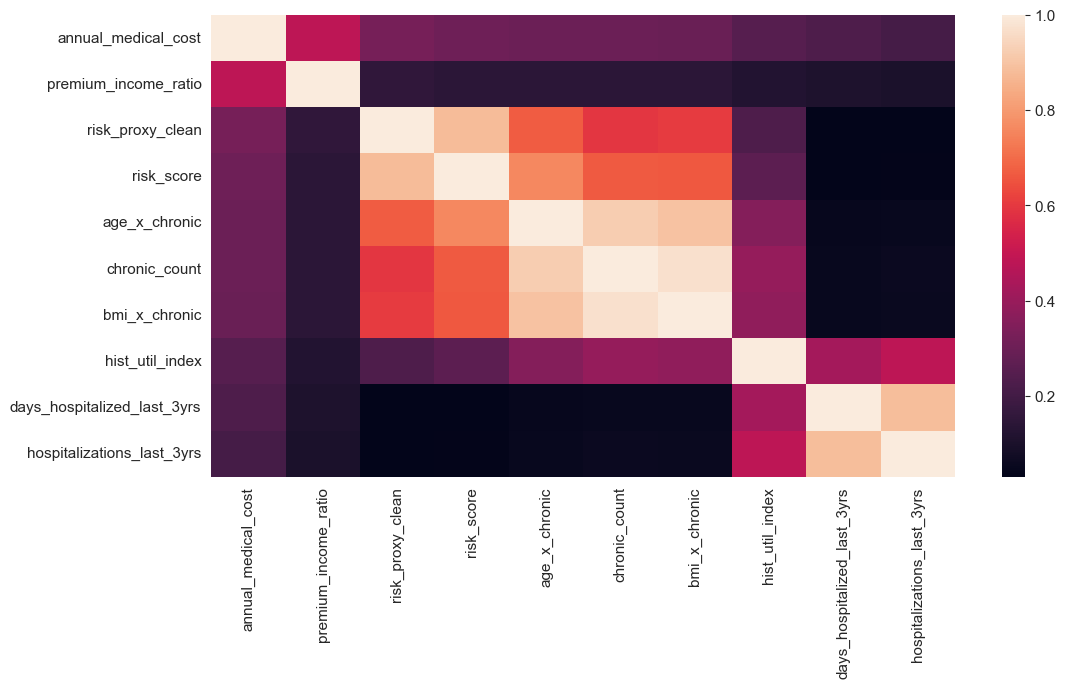

In [75]:
heatmap_datas = data[top_features].copy()
heatmap_corrs = heatmap_datas.corr(numeric_only=True)
sns.heatmap(heatmap_corrs)

In [13]:
data.columns

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'education', 'marital_status', 'employment_status', 'household_size',
       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'chronic_count', 'hypertension', 'diabetes',
       'asthma', 'copd', 'cardiovascular_disease', 'cancer_history',
       'kidney_disease', 'liver_disease', 'arthritis', 'mental_health',
       'proc_imaging_count', 'proc_surgery_count', 'proc_physio_count',
       'proc_consult_count', 'proc_lab_count', 'alcohol_freq_num',
       'gender_num', 'education_num', 'urban_rural_num', 'region_num',
       'smoker_num', 'marital_num', 'employment_num', 'plan_typ

In [14]:
# --- PHASE 4: MODEL CREATION (Baseline Models + Preprocessing Pipeline) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Copy the engineered dataset
data_model = data.copy()

# Drop redundant and target columns
data_model = data_model.drop(columns=['monthly_premium'], errors='ignore')
target = 'annual_medical_cost'

# Define features and target
X = data_model.drop(columns=[target, 'person_id'], errors='ignore')
y = data_model[target]

# Split into train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [col for col in X_train.columns if col not in numeric_features]

# --- PREPROCESSING PIPELINE ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --- BASELINE MODELS ---
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "XGBRegressor":XGBRegressor(
                n_estimators=1000,      # number of boosting rounds
                learning_rate=0.05,    # shrinkage rate
                max_depth=6,           # tree depth
                subsample=0.9,         # fraction of data per tree
                colsample_bytree=0.9,  # fraction of features per tree
                random_state=42,
                min_child_weight=3,
                reg_lambda=1.2,
                reg_alpha=0.5,
                eval_metric='rmse'),
    "RandomForestRegressor":RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    min_samples_split=4,
    min_samples_leaf=2
)
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    preds_test = pipeline.predict(X_test)
    
    val_mae = mean_absolute_error(y_val, preds)
    val_rmse = np.sqrt(mean_squared_error(y_val, preds))
    val_r2 = r2_score(y_val, preds)
    test_mae = mean_absolute_error(y_test, preds_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, preds_test))
    test_r2 = r2_score(y_test, preds_test)
    
    
    results.append({"Model": name, "val_MAE": val_mae, "val_RMSE": val_rmse, "val_R2": val_r2, "test_MAE": test_mae, "test_RMSE": test_rmse, "test_R2": test_r2})

# Convert to DataFrame for display
results_df = pd.DataFrame(results)


In [15]:
results_df

,Model,val_MAE,val_RMSE,val_R2,test_MAE,test_RMSE,test_R2
0,LinearRegression,1514.297744,2422.389769,0.373556,1524.788324,2587.758962,0.350517
1,Ridge,1514.296288,2422.391952,0.373555,1524.788580,2587.762271,0.350515
2,Lasso,1514.297306,2422.389260,0.373556,1524.788217,2587.758125,0.350517
3,XGBRegressor,92.433328,352.882701,0.986706,108.376884,749.908251,0.945457
4,RandomForestRegressor,97.562839,333.142214,0.988152,106.117622,567.722165,0.968740
